In [2]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 90% !important; }</style>"))

In [4]:
import sys

additional_paths = ['../']

for path in additional_paths:
    if path not in sys.path:
        sys.path.append(path)

In [5]:
import utils.pong
import utils.rnn_model
import utils.visualization
import utils.tensorflow

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import sacred

tf.__version__

'2.0.0'

In [6]:
ex = sacred.Experiment(name='RNN Experiment', interactive=True)
ex.observers.append(sacred.observers.MongoObserver())

In [7]:
@ex.capture
def make_dataset(bs, W, H, SEQ_LEN):
    stateful_pong_generator = utils.pong.StatefulPongGenerator(W, H, SEQ_LEN)


    def data_input():
        for (d, c), (f, g) in stateful_pong_generator:
            stateful_pong_generator.stochasticity = np.random.uniform(0, 1)
            yield (np.array([np.sin(d), np.cos(d)]), c), f

    return tf.data.Dataset.from_generator(
        data_input,
        output_types=((tf.float32, tf.float32), tf.float32),
    ).take(8000).cache().repeat().batch(bs).prefetch(tf.data.experimental.AUTOTUNE)

In [8]:
@ex.config
def config():
    SEQ_LEN = 256
    W, H = 40, 40
    internal_size = 32
    batch_size = 128
    steps_per_epoch = 128
    lr = 0.005
    weight_decay = 0.0001

In [9]:
def on_batch_begin(model):
    utils.visualization.plot_pairwise_frames(
        sampler=lambda: list(make_dataset(1).take(1))[0],
        hypotheses=lambda x: model.net.predict(x)[0]
    )
    
    if 'loss' in model.net.history.history:
        loss = model.net.history.history['loss'][-1]
        ex.log_scalar('loss', loss)

    pred_rollout_name = 'pred_rollout.png'
    plt.savefig(pred_rollout_name)
    ex.add_artifact(pred_rollout_name)
    plt.show()

In [12]:
@ex.main
def main(
    SEQ_LEN,
    W, H,
    internal_size,
    batch_size,
    steps_per_epoch,
    lr,
    weight_decay,
):
    #### Model
    model = utils.rnn_model.Model(internal_size=internal_size, W=W, H=H, lr=lr, weight_decay=weight_decay)
    model.net.summary()

    model_img_name = 'model.png'
    tf.keras.utils.plot_model(model.net, to_file=model_img_name, show_shapes=True, expand_nested=False, rankdir='TB', dpi=90)
    ex.add_artifact(model_img_name)
    
    #### Callbacks
    callbacks = [
        utils.tensorflow.model_persistor(model),
        utils.tensorflow.on_batch_begin(lambda: on_batch_begin(model)),
        model.tb_callback
    ]
    
    #### Training
    input_generator = make_dataset(bs=batch_size)
    model.net.fit_generator(
        generator=input_generator,
        validation_data=input_generator,
        validation_steps=2,
        steps_per_epoch=steps_per_epoch,
        epochs=2000,
        callbacks=callbacks
    )

INFO - RNN Experiment - Running command 'main'
INFO - RNN Experiment - Started run with ID "14"


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
game_init (InputLayer)          [(None, 2)]          0                                            
__________________________________________________________________________________________________
user_input (InputLayer)         [(None, None, 2)]    0                                            
__________________________________________________________________________________________________
project_activation (Dense)      (None, 32)           96          game_init[0][0]                  
__________________________________________________________________________________________________
gru (GRU)                       (None, None, 32)     3456        user_input[0][0]                 
                                                                 project_activation[0][0]   

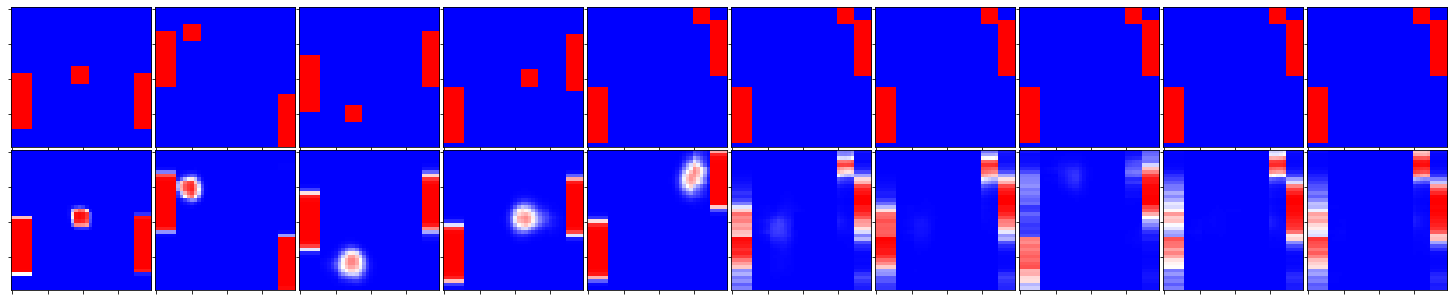

Epoch 1/2000
  4/128 [..............................] - ETA: 2:14 - loss: 0.0841 - mse: 0.0215

WARNING - RNN Experiment - Aborted after 0:00:08!


KeyboardInterrupt: 

In [14]:
ex.run()